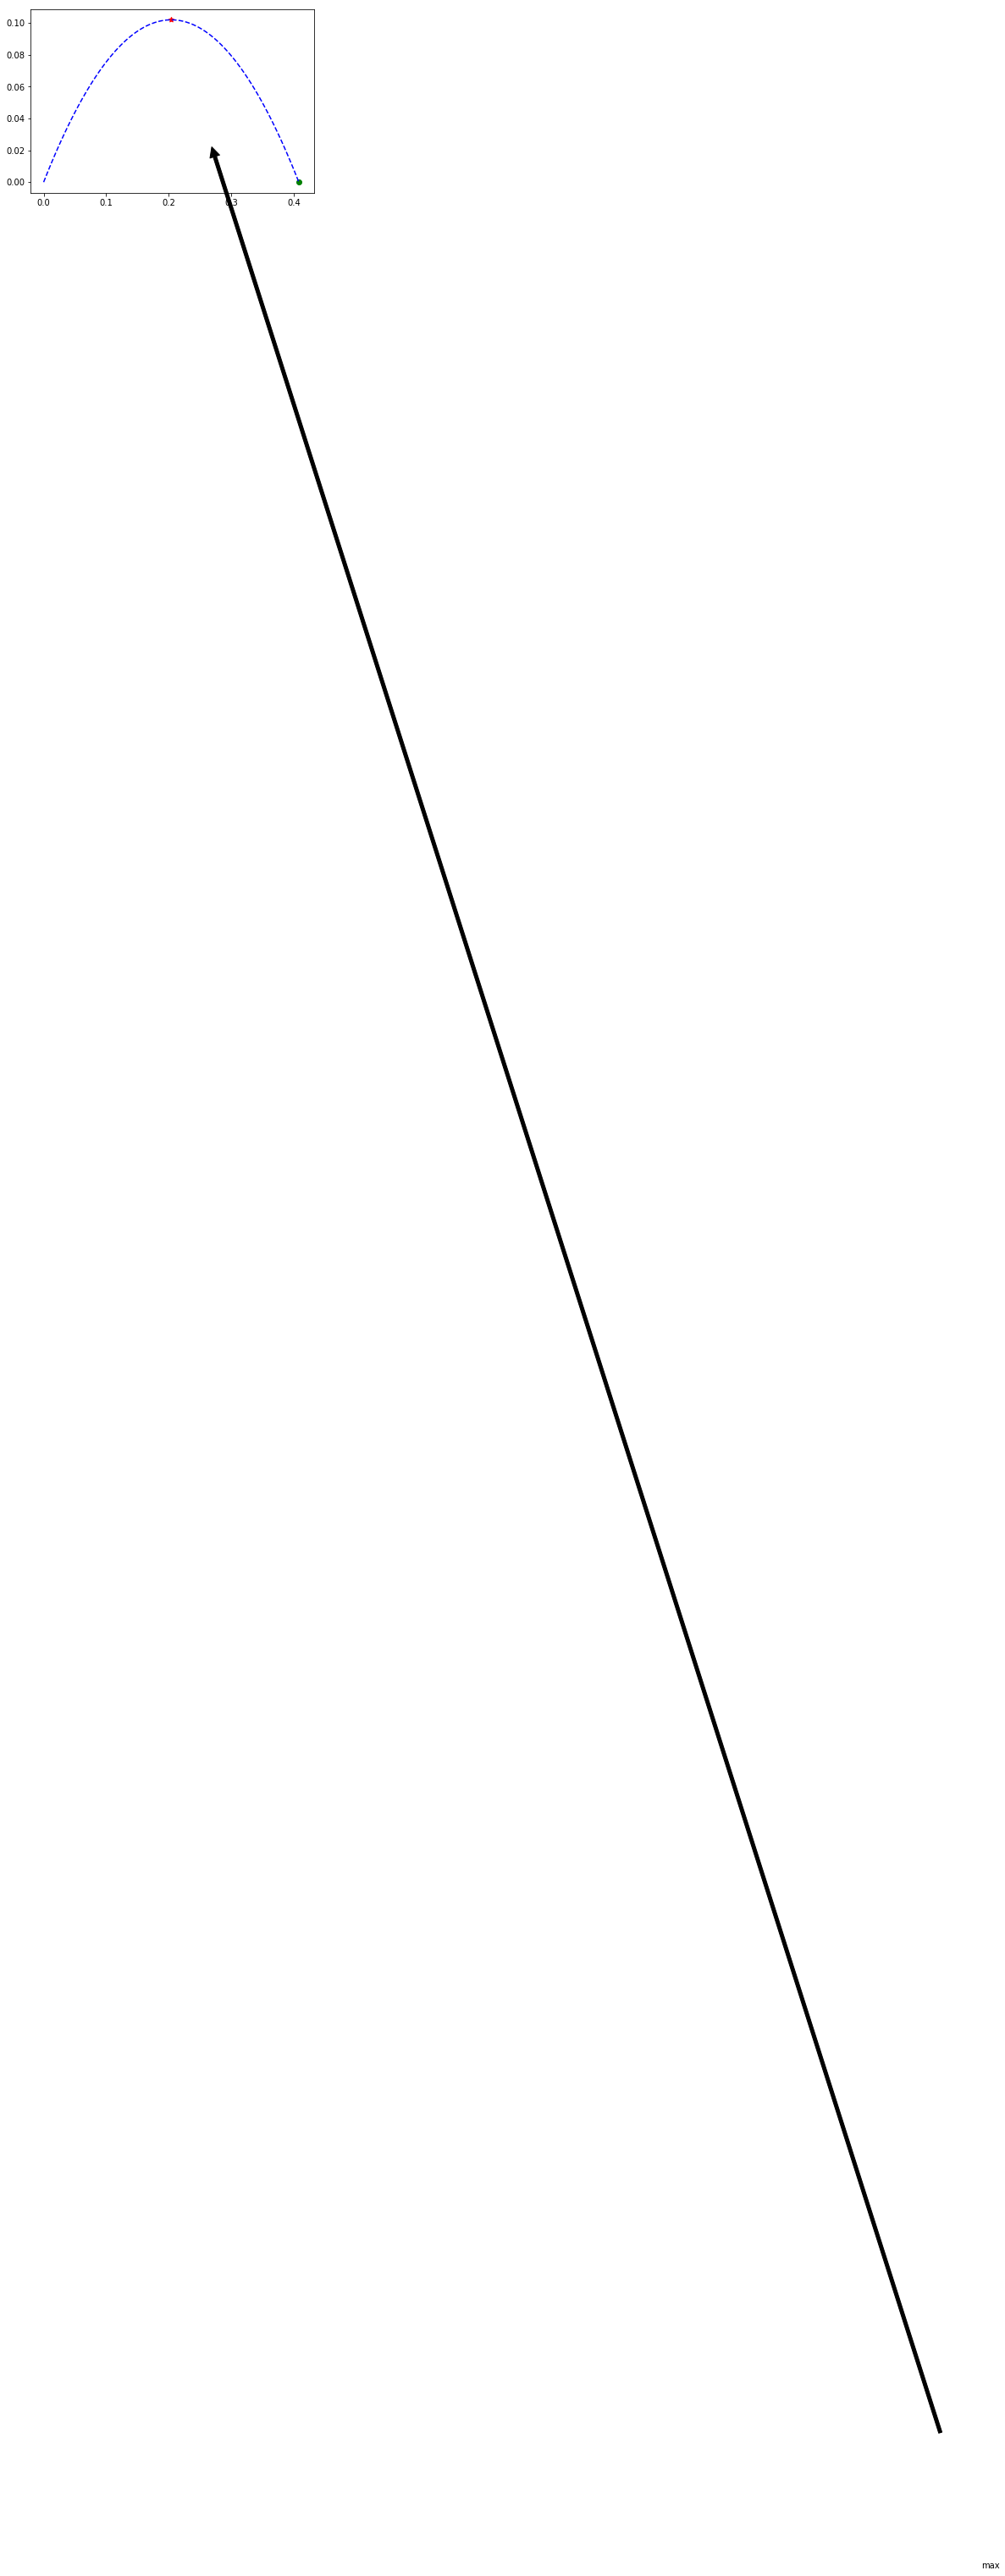

In [8]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jan 25 16:49:49 2018
@author: 1203087
"""

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

tf.set_random_seed(1)
np.random.seed(1)

# fake data
vel   = np.random.random(size=1000)
theta = np.random.randint(1,90,size=1000)
inputs = np.stack((vel, theta), axis=-1)
#print(inputs.shape)

r    = vel*vel*np.sin(2*np.radians(theta)) / 9.8
h    = vel*vel*np.sin(np.radians(theta))*np.sin(np.radians(theta)) / 19.6
ans = np.stack((r, h), axis=-1)
#print(vel[10],theta[10],r[10],h[10])

def f(v, th, x):
    return np.tan(np.radians(th)) * x - 4.9 * x * x / (v * v * np.cos(np.radians(th)) * np.cos(np.radians(th)))

def range(v , th):
    return v*v*np.sin(2*np.radians(th)) / 9.8

def heigh(v , th):
    return v*v*np.sin(np.radians(th))*np.sin(np.radians(th)) / 19.6

#x = np.linspace(0, range(2 , 45), 100)
#plt.plot(x, f(2, 45, x), 'b--')
#plt.scatter(0.5*range(2 , 45), heigh(2 , 45),c='r',marker=(5, 1))
#plt.scatter(range(2 , 45), 0,c='g')
##plt.annotate('max', xy=(0.5*range(2 , 45), heigh(2 , 45)), xytext=(1.5, -1.5), arrowprops=dict(facecolor='black', shrink=0.05), )
#plt.show()

In [ ]:
with tf.variable_scope('Inputs'):
    tf_inputs = tf.placeholder(tf.float32, [None, 2], name='inputs')

with tf.variable_scope('Ans'):
    tf_ans = tf.placeholder(tf.float32, [None, 2], name='answers')

with tf.variable_scope('Net'):
    l1 = tf.layers.dense(tf_inputs, 5, tf.nn.relu, name='hidden_layer1')
    l2 = tf.layers.dense(l1, 5, tf.nn.relu, name='hidden_layer2')
    output = tf.layers.dense(l2, 2, name='output_layer')

    # add to histogram summary
    tf.summary.histogram('h1_out', l1)
    tf.summary.histogram('h2_out', l2)
    tf.summary.histogram('pred', output)

loss = tf.losses.mean_squared_error(tf_ans, output, scope='loss')
train_op = tf.train.GradientDescentOptimizer(learning_rate=0.05).minimize(loss)
tf.summary.scalar('loss', loss)     # add loss to scalar summary

sess = tf.Session()
sess.run(tf.global_variables_initializer())

writer = tf.summary.FileWriter('./log', sess.graph)     # write to file
merge_op = tf.summary.merge_all() # operation to merge all summary

plt.ion()   # something about plotting
for step in range(1000):
    # train and net output
    _, l, pred = sess.run([train_op, loss, output], {tf_inputs: inputs, tf_ans: ans})
    if step % 10 == 0:
        # plot and show learning process

        #print('step: ', step, 'loss: ', l)
        plt.pause(0.1)

sess.close()
plt.ioff()
plt.show()